<a href="https://colab.research.google.com/github/MontyRex/ML-labs/blob/main/6(%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F)_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ практика 6. Обучение без учителя

## **Цель занятия:**
Изучить методы обучения без учителя, познакомиться с алгоритмами кластеризации, понять их применение и реализовать модели кластеризации с использованием различных алгоритмов.

## **Задание состоит из следующих частей:**
1. Определение обучения без учителя
2. Разбор алгоритмов DBSSCAN, K-means
3. Метрики качества кластеризации
4. Пример полезных задач, которые решает кластеризация

**P.S.** Некоторые вещи (например PCA, обработка текстовых данных) мы пройдем чуть позже.

## Задачи для домашки ⏰

1. Преобразовать датасет
2. Построить кластеры
3. Описать результат полученных кластеров (для K-Means и DBSSCAN)
4. Объяснить метрики качества

**По желанию**

1. Спарсить данные по статьям (например lenta.ru или naked-science.ru)
2. Преобразовать текста статьи (по принципу описанному в последнем пункте)
3. Оценить метрики качества, провести аналитику кластеров (можно не максимально подробно, если получилось слишком много кластеров)

## Предобработка (все по классике)

Открываем датасет, преобразуем данные, идем дальше

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка набора данных
df = pd.read_csv('/content/employee.csv')

In [2]:
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department,salary,left
0,0.38,0.53,2,157,3,0,0,sales,low,1
1,0.80,0.86,5,262,6,0,0,sales,medium,1
2,0.11,0.88,7,272,4,0,0,sales,medium,1
3,0.72,0.87,5,223,5,0,0,sales,low,1
4,0.37,0.52,2,159,3,0,0,sales,low,1
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,0,support,low,1
14995,0.37,0.48,2,160,3,0,0,support,low,1
14996,0.37,0.53,2,143,3,0,0,support,low,1
14997,0.11,0.96,6,280,4,0,0,support,low,1


### Преобразование категориальных фич

In [3]:
df['time_spend_company'] = df['time_spend_company'].astype('category')
df['Work_accident'] = df['Work_accident'].astype('category')
df['promotion_last_5years'] = df['promotion_last_5years'].astype('category')
df['department'] = df['department'].astype('category')
df['salary'] = df['salary'].astype('category')
df['left'] = df['left'].astype('category')
df['number_project'] = df['number_project'].astype('category')
# Создаем копию данных
category_columns: list[str] = df.select_dtypes(include=['category']).columns

# Применяем One-Hot Encoding
df = pd.get_dummies(df, columns=category_columns, drop_first=True)



### Преобразование непрерывных фич

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   satisfaction_level       14999 non-null  float64
 1   last_evaluation          14999 non-null  float64
 2   average_montly_hours     14999 non-null  int64  
 3   number_project_3         14999 non-null  bool   
 4   number_project_4         14999 non-null  bool   
 5   number_project_5         14999 non-null  bool   
 6   number_project_6         14999 non-null  bool   
 7   number_project_7         14999 non-null  bool   
 8   time_spend_company_3     14999 non-null  bool   
 9   time_spend_company_4     14999 non-null  bool   
 10  time_spend_company_5     14999 non-null  bool   
 11  time_spend_company_6     14999 non-null  bool   
 12  time_spend_company_7     14999 non-null  bool   
 13  time_spend_company_8     14999 non-null  bool   
 14  time_spend_company_10 

In [5]:
from sklearn.preprocessing import MinMaxScaler
# Выбираем числовые признаки
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
df[numeric_features] = scaler.fit_transform(df[numeric_features])

numer = df[numeric_features]


In [6]:
df

,satisfaction_level,last_evaluation,average_montly_hours,number_project_3,number_project_4,number_project_5,number_project_6,number_project_7,time_spend_company_3,time_spend_company_4,...,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium,left_1
0,0.318681,0.265625,0.285047,False,False,False,False,False,True,False,...,False,False,False,False,True,False,False,True,False,True
1,0.780220,0.781250,0.775701,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,True,True
2,0.021978,0.812500,0.822430,False,False,False,False,True,False,True,...,False,False,False,False,True,False,False,False,True,True
3,0.692308,0.796875,0.593458,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,True,False,True
4,0.307692,0.250000,0.294393,False,False,False,False,False,True,False,...,False,False,False,False,True,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.340659,0.328125,0.257009,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,True,False,True
14995,0.307692,0.187500,0.299065,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,True,False,True
14996,0.307692,0.265625,0.219626,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,True,False,True
14997,0.021978,0.937500,0.859813,False,False,False,True,False,False,True,...,False,False,False,False,False,True,False,True,False,True


## О кластеризации и задачи обучения без учителя

#### Обучение с учителем

Представьте, что у вас есть список задач с правильными ответами. Например, вам дали примеры: «Это яблоко», «Это груша».

Задача — научиться отличать их, чтобы потом, когда вы увидите новый фрукт, вы смогли правильно его назвать. То есть у вас есть **учитель** — тот, кто заранее всё объяснил и дал правильные ответы.  

#### Обучение без учителя

А теперь представьте, что вам дали корзину фруктов, но никто не сказал, как они называются.

Задача — посмотреть на фрукты и найти, что у них общего, например: круглые положить в одну группу, длинные в другую. Тут вы работаете **без подсказок** и сами решаете, как группировать.  

#### Разница

- В задачах с учителем есть правильные ответы, и мы обучем алгоритм делать предсказания на основе примеров.  
- В задачах без учителя правильных ответов нет, ищем закономерности и пытаемся найти смысл группировки данные самостоятельно.

Пример:


1. **С учителем**: Мы ищем лучшее вино.  
2. **Без учителя**: Мы пытаемся объеденить вина, чтобы понять по какому принципу они объеденяются.  

## K-means

**K-means** — это алгоритм кластеризации, который делит данные на 𝑘 групп (кластеров). Основная идея: найти центры кластеров так, чтобы точки внутри одного кластера были ближе друг к другу, чем к точкам из других кластеров.

1. Инициализация: выбираем 𝑘 случайных центров (центроидов).
2. Присвоение точек: каждая точка относится к ближайшему центру.
Обновление центров: пересчитываем центры кластеров как среднее всех точек в кластере.
3. Повторяем шаги 2–3, пока центры не перестанут меняться или не достигнем максимального числа итераций.

In [7]:
! pip install ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.6 MB/s eta 0:00:00


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

def interactive_kmeans_visualization(X, max_clusters=10, max_iterations=50):

    # преобразуем X в numpy array
    if isinstance(X, pd.DataFrame):
        X = X.values

    def plot_kmeans_iteration(X, centroids, labels=None, step=0):
        clear_output(wait=True)
        plt.figure(figsize=(8, 6))
        if labels is not None:
            plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30, alpha=0.6)
        else:
            plt.scatter(X[:, 0], X[:, 1], s=30, alpha=0.6)
        plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label='Centroids')
        plt.title(f'K-means Iteration {step}')
        plt.legend()
        plt.show()

    def k_means_interactive(X, k, max_iters):
        np.random.seed(42)
        centroids = X[np.random.choice(X.shape[0], k, replace=False)]
        for step in range(max_iters):
            distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
            labels = np.argmin(distances, axis=1)
            plot_kmeans_iteration(X, centroids, labels, step)
            new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
            if np.all(centroids == new_centroids):
                break
            centroids = new_centroids

    def run_kmeans(k, max_iters):
        k_means_interactive(X, k, max_iters)

    k_slider = widgets.IntSlider(value=3, min=2, max=max_clusters, step=1, description='Clusters (k):')
    iter_slider = widgets.IntSlider(value=10, min=1, max=max_iterations, step=1, description='Max Iterations:')

    interactive_plot = widgets.interactive(run_kmeans, k=k_slider, max_iters=iter_slider)
    display(interactive_plot)

# Берем датасет и визуализируем K-means
interactive_kmeans_visualization(numer[:100])


interactive(children=(IntSlider(value=3, description='Clusters (k):', max=10, min=2), IntSlider(value=10, desc…

### K-means через реализацию skelarn

In [9]:
kmeans_data = pd.read_csv('/content/employee.csv')
category_columns: list[str] = kmeans_data.select_dtypes(include=['object']).columns

# Применяем One-Hot Encoding
kmeans_data = pd.get_dummies(kmeans_data, columns=category_columns, drop_first=True)
kmeans_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   satisfaction_level      14999 non-null  float64
 1   last_evaluation         14999 non-null  float64
 2   number_project          14999 non-null  int64  
 3   average_montly_hours    14999 non-null  int64  
 4   time_spend_company      14999 non-null  int64  
 5   Work_accident           14999 non-null  int64  
 6   promotion_last_5years   14999 non-null  int64  
 7   left                    14999 non-null  int64  
 8   department_RandD        14999 non-null  bool   
 9   department_accounting   14999 non-null  bool   
 10  department_hr           14999 non-null  bool   
 11  department_management   14999 non-null  bool   
 12  department_marketing    14999 non-null  bool   
 13  department_product_mng  14999 non-null  bool   
 14  department_sales        14999 non-null

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Определяем количество кластеров k
k = 5  # Вы можете изменить это значение в соответствии с вашими данными

# Создаем и обучаем модель KMeans
kmeans = KMeans(n_clusters=k, random_state=42, algorithm='elkan')
labels = kmeans.fit_predict(df)
centroids = kmeans.cluster_centers_

# Добавляем метки кластеров в исходный DataFrame
df_k_means = numer
df_k_means['Cluster'] = labels

# Вывод статистики по кластерам для каждого признака
print("Статистика по кластерам:")
for column in numer.columns:
    print(f"\nСтатистика для признака '{column}':")
    cluster_stats = df_k_means.groupby('Cluster')[column].agg(['mean', 'std', 'min', 'max'])
    print(cluster_stats)

# Вычисление коэффициента силуэта
if k > 1:
    silhouette_avg = silhouette_score(numer, labels)
    print(f"\nКоэффициент силуэта для k={k}: {silhouette_avg:.4f}")
else:
    print("\nКоэффициент силуэта не определен для k=1")


<ipython-input-15-6ab1153add0d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_k_means['Cluster'] = labels


Статистика по кластерам:

Статистика для признака 'satisfaction_level':
             mean       std       min       max
Cluster                                        
0        0.654280  0.213664  0.032967  1.000000
1        0.659909  0.227936  0.021978  1.000000
2        0.352098  0.068086  0.010989  0.945055
3        0.637425  0.235367  0.000000  1.000000
4        0.402001  0.361651  0.000000  1.000000

Статистика для признака 'last_evaluation':
             mean       std  min  max
Cluster                              
0        0.558571  0.248063  0.0  1.0
1        0.578358  0.255219  0.0  1.0
2        0.244013  0.091597  0.0  1.0
3        0.563492  0.257368  0.0  1.0
4        0.711450  0.230479  0.0  1.0

Статистика для признака 'average_montly_hours':
             mean       std       min       max
Cluster                                        
0        0.474147  0.209338  0.000000  0.995327
1        0.502934  0.211430  0.000000  0.957944
2        0.236209  0.096867  0.023364  1.

#### **Анализ кластеров**



Мы получаем 5 кластеров, которые мы можем разделить на две группы, 2, 4 выделяющиеся и 0, 1, 3 большинство средних.

По удовлетворенности работой выделяются первые два кластера неудовлетворенных, по их оценке эффективности выделются среди них те, кто либо очень плохо проявил себя, либо очень хорошо соответственно. Как и по среднему количеству часов в месяц выделяются те кто работал очень мало, и те кто очень много.

**Коэффициент силуэта для Kmeans:** 0.5657

**Общее заключение:**

Алгоритм Kmeans успешно разделил работников на 5 кластеров, которые можно поделить на две группы по типу (довольные и недовольные), при этом определив для нас какие работники неудовлетворены, что соответствует данным, полученным нами в прошлых лабораторных работах.

Коэффициент силуэта — это метрика для оценки качества кластеризации, показывающая, насколько объекты внутри одного кластера похожи друг на друга и отличаются от объектов в других кластерах.

- **Диапазон значений:** от -1 до 1.
  - **Близкие к 1:** Хорошая кластеризация; объекты внутри кластеров схожи, кластеры хорошо разделены.
  - **Около 0:** Кластеры пересекаются; объекты находятся на границах кластеров.
  - **Отрицательные значения:** Плохая кластеризация; объекты могут быть отнесены к неправильным кластерам.

**Интерпретация полученного значения:**

- **0.3420** — это положительное значение, указывающее на удовлетворительное качество кластеризации.
- Кластеры достаточно хорошо разделены, но есть пересечение между ними.

Кластеризация позволила выделить группы вин, отличающиеся по типу (белое или красное), содержанию алкоголя и уровню остаточного сахара.

### DBSSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) — это алгоритм кластеризации, основанный на плотности точек в пространстве.

Параметры алгоритма:

- **Epsilon (eps)**: радиус окрестности точки.
- **Min_samples**: минимальное количество точек в eps-окрестности для того, чтобы точка считалась ядром кластера.

Классификация точек:

- **Core point (ядро)**: если в eps-окрестности точки находится не менее min_samples точек, то она является ядром.
- **Border point (граничная точка)**: точка, которая находится в eps-окрестности ядра, но сама не является ядром.
- **Noise point (шум)**: точка, которая не является ни ядром, ни граничной точкой. (**входит в кластер -1**)

Точки, которые связаны по плотности (через ядра и их eps-окрестности), объединяются в один кластер.

In [17]:
df

,satisfaction_level,last_evaluation,average_montly_hours,number_project_3,number_project_4,number_project_5,number_project_6,number_project_7,time_spend_company_3,time_spend_company_4,...,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium,left_1
0,0.318681,0.265625,0.285047,False,False,False,False,False,True,False,...,False,False,False,False,True,False,False,True,False,True
1,0.780220,0.781250,0.775701,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,True,True
2,0.021978,0.812500,0.822430,False,False,False,False,True,False,True,...,False,False,False,False,True,False,False,False,True,True
3,0.692308,0.796875,0.593458,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,True,False,True
4,0.307692,0.250000,0.294393,False,False,False,False,False,True,False,...,False,False,False,False,True,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.340659,0.328125,0.257009,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,True,False,True
14995,0.307692,0.187500,0.299065,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,True,False,True
14996,0.307692,0.265625,0.219626,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,True,False,True
14997,0.021978,0.937500,0.859813,False,False,False,True,False,False,True,...,False,False,False,False,False,True,False,True,False,True


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display, clear_output
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

def interactive_dbscan_visualization(X):
    if isinstance(X, pd.DataFrame):
        X = X.values

    def plot_dbscan(X, labels, core_samples_mask, eps, min_samples, metric):
        clear_output(wait=True)
        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each)
                  for each in np.linspace(0, 1, len(unique_labels))]
        plt.figure(figsize=(8, 6))
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Черный цвет для шума
                col = [0, 0, 0, 1]

            class_member_mask = (labels == k)

            xy = X[class_member_mask & core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=14)

            xy = X[class_member_mask & ~core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=6)

        plt.title(f'DBSCAN: eps={eps}, min_samples={min_samples}, metric={metric}')
        plt.show()

    def run_dbscan(eps, min_samples, metric):
        # Обучение DBSCAN
        db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
        db.fit(X)
        labels = db.labels_
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        plot_dbscan(X, labels, core_samples_mask, eps, min_samples, metric)

    # Виджеты для настройки параметров
    eps_slider = widgets.FloatSlider(value=0.5, min=0.1, max=1.0, step=0.05, description='eps:')
    min_samples_slider = widgets.IntSlider(value=5, min=1, max=20, step=1, description='min_samples:')
    metric_dropdown = widgets.Dropdown(options=['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
                                       value='euclidean', description='metric:')

    ui = widgets.VBox([eps_slider, min_samples_slider, metric_dropdown])
    out = widgets.interactive_output(run_dbscan, {'eps': eps_slider, 'min_samples': min_samples_slider, 'metric': metric_dropdown})
    display(ui, out)

# Пример использования
interactive_dbscan_visualization(df[:120])


Output()

### DBSSCAN через sklearn

Количество кластеров: 5
Статистика по кластерам:

Статистика для признака 'satisfaction_level':
             mean       std       min       max  count
Cluster                                               
0        0.352098  0.068086  0.010989  0.945055   1613
1        0.402001  0.361651  0.000000  1.000000   2515
2        0.659909  0.227936  0.021978  1.000000   3212
3        0.654280  0.213664  0.032967  1.000000   2191
4        0.637425  0.235367  0.000000  1.000000   5468

Статистика для признака 'last_evaluation':
             mean       std  min  max  count
Cluster                                     
0        0.244013  0.091597  0.0  1.0   1613
1        0.711450  0.230479  0.0  1.0   2515
2        0.578358  0.255219  0.0  1.0   3212
3        0.558571  0.248063  0.0  1.0   2191
4        0.563492  0.257368  0.0  1.0   5468

Статистика для признака 'average_montly_hours':
             mean       std       min       max  count
Cluster                                               
0

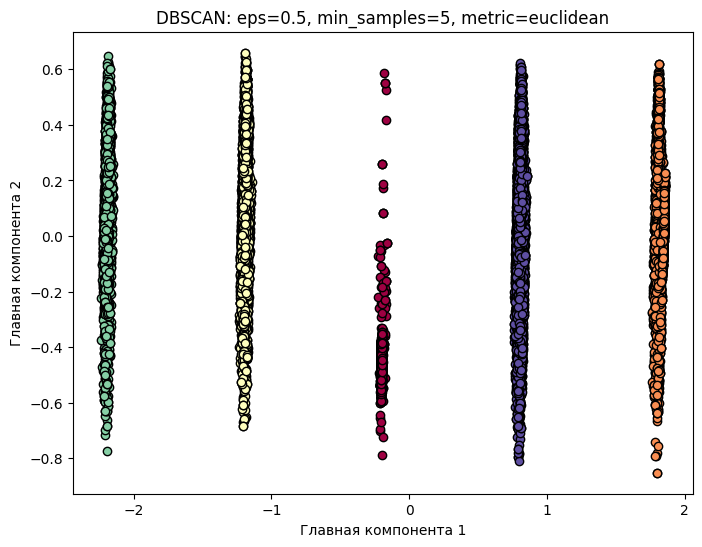

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Параметры DBSCAN
eps = 0.5
min_samples = 5
metric = 'euclidean'

# Обучение модели DBSCAN
db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
labels = db.fit_predict(numer)

# Добавляем метки кластеров в DataFrame
df_dbscan = numer.copy()
df_dbscan['Cluster'] = labels

# Количество кластеров (исключая шум)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Количество кластеров: {n_clusters_}")

# Вывод статистики по кластерам
print("Статистика по кластерам:")
for column in numer.columns:
    print(f"\nСтатистика для признака '{column}':")
    cluster_stats = df_dbscan[df_dbscan['Cluster'] != -1].groupby('Cluster')[column].agg(['mean', 'std', 'min', 'max', 'count'])
    print(cluster_stats)

# Вычисление коэффициента силуэта
if n_clusters_ > 1:
    silhouette_avg = silhouette_score(numer[df_dbscan['Cluster'] != -1], labels[df_dbscan['Cluster'] != -1])
    print(f"\nКоэффициент силуэта для DBSCAN: {silhouette_avg:.4f}")
else:
    print("\nКоэффициент силуэта не определен, так как найден один кластер или данные являются шумом.")


# Визуализация результатов (с использованием PCA для снижения размерности)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(numer)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['Cluster'] = labels

plt.figure(figsize=(8, 6))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    if k == -1:
        # Черный цвет для шума
        col = [0, 0, 0, 1]
    plt.plot(df_pca.loc[class_member_mask, 'PC1'],
             df_pca.loc[class_member_mask, 'PC2'],
             'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title(f'DBSCAN: eps={eps}, min_samples={min_samples}, metric={metric}')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.show()


#### **Анализ кластеров**

Получаем **5 кластеров**, которые мы можем разделить на две группы, 0, 1 выделяющиеся и 2, 3, 4 большинство средних.

По удовлетворенности работой выделяются первые два кластера неудовлетворенных, по их оценке эффективности выделются среди них те, кто либо очень плохо проявил себя, либо очень хорошо соответственно. Как и по среднему количеству часов в месяц выделяются те кто работал очень мало, и те кто очень много.

**Коэффициент силуэта для DBSCAN:** 0.5657

**Общее заключение:**

Алгоритм DBSCAN успешно разделил работников на два кластера из пяти подкластеров по типу (довольные и недовольные), при этом определив для нас какие работники неудовлетворены, что соответствует данным, полученным нами в прошлых лабораторных работах

### Метрики качества кластеризации

**Дополнительные метрики для оценки качества кластеризации**

Кроме коэффициента силуэта, существуют и другие метрики, которые помогают оценить качество кластеризации. Вот некоторые из них:

1. **Индекс Калински-Харабаза (Calinski-Harabasz Index):**
   - **Описание:** Измеряет отношение между разбросом между кластерами и разбросом внутри кластеров.
   - **Диапазон значений:** От 0 до бесконечности.
   - **Интерпретация:** Чем ближе к бесконечности больше, тем лучше раздленеие между кластерами

2. **Индекс Дэвиса-Болдина (Davies-Bouldin Index):**
   - **Описание:** Оценивает среднее "сходство" между каждым кластером и наиболее похожим на него другим кластером. Сходство основано на расстоянии между кластерами и их размером.
   - **Диапазон значений:** От 0 до бесконечности.
   - **Интерпретация:** Чем ближе к 0, тем лучшее разделение между кластерами.

3. **Коэффициент силуэта (Silhouette Score):**

    - **Описание:** Измеряет, насколько объект похож на свой кластер по сравнению с другими кластерами.
    - **Диапазон значений:** От -1 до 1.
    - **Интерпретация:** Значения, близкие к 1, указывают на хорошую кластеризацию. Значения около 0 означают, что кластеры перекрываются. Отрицательные значения указывают на возможные ошибки в кластеризации.

In [19]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
# Кластеризация K-means
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
labels_kmeans = kmeans.fit_predict(numer)

# Индекс Калински-Харабаза
ch_score_kmeans = calinski_harabasz_score(numer, labels_kmeans)
print(f"Индекс Калински-Харабаза для K-means: {ch_score_kmeans:.4f}")

# Индекс Дэвиса-Болдина
db_score_kmeans = davies_bouldin_score(numer, labels_kmeans)
print(f"Индекс Дэвиса-Болдина для K-means: {db_score_kmeans:.4f}")

# Коэффициент силуэта
sh_score_kmeans = silhouette_score(numer, labels_kmeans)
print(f"Коэффициент силуэта для K-means: {sh_score_kmeans:.4f}")

Индекс Калински-Харабаза для K-means: 43027.9263
Индекс Дэвиса-Болдина для K-means: 0.7112
Коэффициент силуэта для K-means: 0.5657


In [20]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

eps = 0.5
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels_dbscan = dbscan.fit_predict(numer)

# Исключаем шумовые точки (метки -1)
mask = labels_dbscan != -1
df_scaled_dbscan = numer[mask]
labels_dbscan_filtered = labels_dbscan[mask]

# Проверяем, есть ли достаточное количество кластеров для расчета метрик
if len(set(labels_dbscan_filtered)) > 1:
    # Индекс Калински-Харабаза
    ch_score_dbscan = calinski_harabasz_score(df_scaled_dbscan, labels_dbscan_filtered)
    print(f"Индекс Калински-Харабаза для DBSCAN: {ch_score_dbscan:.4f}")

    # Индекс Дэвиса-Болдина
    db_score_dbscan = davies_bouldin_score(df_scaled_dbscan, labels_dbscan_filtered)
    print(f"Индекс Дэвиса-Болдина для DBSCAN: {db_score_dbscan:.4f}")

    # Коэффициент силуэта
    sh_score_dbscan = silhouette_score(df_scaled_dbscan, labels_dbscan_filtered)
    print(f"Коэффициент силуэта для DBSCAN: {sh_score_dbscan:.4f}")
else:
    print("Недостаточно кластеров для вычисления метрик для DBSCAN.")


Индекс Калински-Харабаза для DBSCAN: 43027.9263
Индекс Дэвиса-Болдина для DBSCAN: 0.7112
Коэффициент силуэта для DBSCAN: 0.5657


#### Визуальный пример

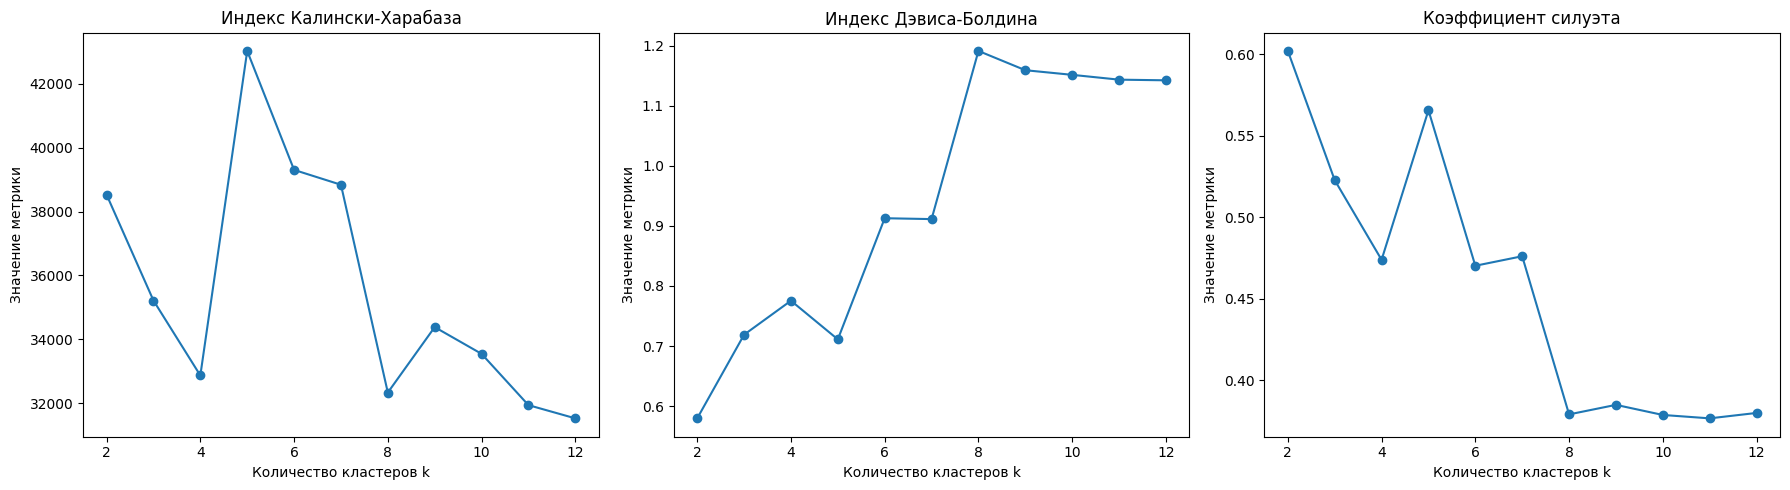

In [21]:
# Диапазон значений k
k_range = range(2, 13)

# Списки для хранения метрик
ch_scores = []
db_scores = []
silhouette_scores = []

for k in k_range:
    # Создаем и обучаем модель KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(numer)

    # Вычисляем метрики
    ch_score = calinski_harabasz_score(numer, labels)
    db_score = davies_bouldin_score(numer, labels)
    silhouette_avg = silhouette_score(numer, labels)

    # Сохраняем метрики
    ch_scores.append(ch_score)
    db_scores.append(db_score)
    silhouette_scores.append(silhouette_avg)

# Построение графиков
plt.figure(figsize=(18, 5))

# График Индекса Калински-Харабаза
plt.subplot(1, 3, 1)
plt.plot(k_range, ch_scores, marker='o')
plt.title('Индекс Калински-Харабаза')
plt.xlabel('Количество кластеров k')
plt.ylabel('Значение метрики')

# График Индекса Дэвиса-Болдина
plt.subplot(1, 3, 2)
plt.plot(k_range, db_scores, marker='o')
plt.title('Индекс Дэвиса-Болдина')
plt.xlabel('Количество кластеров k')
plt.ylabel('Значение метрики')

# График Коэффициента силуэта
plt.subplot(1, 3, 3)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Коэффициент силуэта')
plt.xlabel('Количество кластеров k')
plt.ylabel('Значение метрики')

plt.tight_layout()
plt.show()


# ***Мы выбрали 5 кластеров для k-means до этого и сейчас мы видим, что выбор был правильным.***

**По индексу Калински-Харабаза, чем выше значение, тем лучше. Самое высокое на 5. Успех.**

**По индексу Дэвиса-Болдина чем ближе к нулю, тем лучше. Помимо минимального количества кластеров самый лучший результат на 5. Успех.**

**По коэффициенту силуэта самый лучший результат помимо минимального количества кластеров - 5. Успех.**

**Вывод: количество кластеров в ручную было выбрано оптимальное, DBSCANS сделал тот же выбор.**


# Пример обработки текстовых данных

In [23]:
pip install nltk pymorphy2 scikit-learn


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 60.9 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=b301119073a85beb68fa9d4767a2785c619dce7481d55b07f983447759d14b91
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built docopt


In [24]:
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pymorphy2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Инициализация текстовых анализаторов

In [ ]:
# Инициализируем лемматизатор и список стоп-слов
morph = pymorphy2.MorphAnalyzer()
russian_stopwords = stopwords.words('russian')

# Чтение данных из файла
with open('/content/articles.txt', 'r', encoding='utf-8') as f:
    content = f.read()

# Разделяем данные на статьи
articles_raw = content.split('=====')

# Извлекаем заголовки и тексты статей
titles = []
texts = []

for article in articles_raw:
    lines = article.strip().split('\n')
    if len(lines) >= 6:
        # Извлекаем заголовок и текст статьи
        title = lines[4]
        text = ' '.join(lines[5:])
        titles.append(title)
        texts.append(text)

In [ ]:
texts[:2]

#### Предварительная обработка текстовых данных

1. преобразуем в lowercase
2. оставляем только слова
3. токенизируем текста
4. преобразуем слова в начальную форму

In [ ]:
russian_stopwords

In [ ]:
def preprocess_text(text):
    # Приводим к нижнему регистру
    text = text.lower()
    # Удаляем пунктуацию и цифры
    text = re.sub(r'[^а-яё\s]', '', text)
    # Токенизация
    words = text.split()
    # Удаление стоп-слов и лемматизация
    lemmatized = []
    for word in words:
        if word not in russian_stopwords:
            lemma = morph.parse(word)[0].normal_form
            lemmatized.append(lemma)
    return ' '.join(lemmatized)

# Применяем предобработку к каждому тексту
texts_preprocessed = [preprocess_text(text) for text in texts]


In [ ]:
texts_preprocessed[:2]

#### Преобразуем в векторный вид

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts_preprocessed)


In [ ]:
# Параметры DBSCAN могут требовать подбора
dbscan = DBSCAN(eps=0.5, min_samples=2, metric='cosine')
labels = dbscan.fit_predict(X)


In [ ]:
# Создаем DataFrame с заголовками и метками кластеров
df = pd.DataFrame({'title': titles, 'label': labels})

# Выводим количество кластеров
unique_labels = set(labels)
n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
print(f'Количество кластеров: {n_clusters}')

# Анализируем кластеры
for label in unique_labels:
    if label == -1:
        continue  # Пропускаем шум
    cluster_titles = df[df['label'] == label]['title'].head(3)
    print(f'\nКластер {label}:')
    for title in cluster_titles:
        print(f'- {title}')


Количество кластеров: 51

Кластер 0:
- Впервые в мире термоядерную плазму протестировали в токамаке нового поколения 
- Создан самый большой в мире термоядерный стелларатор 

Кластер 1:
- Во «ВКонтакте»  запущена биржа рекламы 
- «ВКонтакте» избавится от назойливой рекламы в ленте новостей 

Кластер 2:
- Первый китайский луноход 
- Миссия «Чанъэ-3»: Китай хочет утвердиться в качестве космической сверхдержавы 
- «Чанъэ-3» сделал фото Земли в высоком разрешении 

Кластер 3:
- Гибридное затмение над Африкой 
- В воскресенье произойдет гибридное солнечное затмение 

Кластер 4:
- LG G Flex: изогнутый – значит гибкий 
- LG G Flex – «первый в мире по-настоящему изогнутый»  смартфон 

Кластер 5:
- Будет ли Сноуден  работать во «ВКонтакте»? 
- Сноуден отказался работать в соцсети «ВКонтакте» 
- Сноуден  начнет работать в «крупнейшем российском сайте» 

Кластер 6:
- Злой двойник Земли 
- 9 самых странных экзопланет 
- Телескоп «Кеплер» обнаружил планету, похожую на Землю 

Кластер 7:
- Черная ды

In [30]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [ ]:
from sklearn.decomposition import PCA
import plotly.graph_objects as go

# Применяем PCA для уменьшения размерности до 3 компонент
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X.toarray())

# Создаем DataFrame для визуализации
df_plot = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'PC3': X_pca[:, 2],
    'title': titles,
    'label': labels
})

# Создаем 3D Scatter Plot
fig = go.Figure(data=[go.Scatter3d(
    x=df_plot['PC1'],
    y=df_plot['PC2'],
    z=df_plot['PC3'],
    mode='markers',
    marker=dict(
        size=5,
        color=df_plot['label'],
        colorscale='Viridis',
        opacity=0.8
    ),
    text=df_plot['title'],
    hovertemplate='%{text}<extra></extra>'
)])

# Настраиваем внешний вид графика
fig.update_layout(
    title='3D PCA визуализация статей',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    margin=dict(l=0, r=0, b=0, t=50)
)

# Генерируем кадры для анимации вращения графика
frames = []
for angle in range(0, 360, 10):
    camera = dict(
        eye=dict(x=2*np.cos(np.radians(angle)), y=2*np.sin(np.radians(angle)), z=1.5)
    )
    frames.append(go.Frame(layout=dict(scene_camera=camera)))

# Добавляем кадры в график
fig.frames = frames

# Добавляем кнопки управления анимацией
fig.update_layout(
    updatemenus=[dict(
        type='buttons',
        showactive=False,
        y=0.8,
        x=1.05,
        xanchor='left',
        yanchor='top',
        buttons=[dict(label='Вращать',
                      method='animate',
                      args=[None, dict(frame=dict(duration=50, redraw=True),
                                       transition=dict(duration=0),
                                       fromcurrent=True,
                                       mode='immediate')])]
    )]
)

# Отображаем график
fig.show()
